In [10]:
import xml.etree.ElementTree as ET
from collections import defaultdict
from datetime import datetime, time

def get_unique_record_types(xml_file):
    # Parse the XML file
    tree = ET.parse(xml_file)
    root = tree.getroot()

    # Get unique Record types
    record_types = {record.get("type") for record in root.findall("Record")}
    return record_types

def get_records_by_type(xml_file, record_type):
    # Parse the XML file
    tree = ET.parse(xml_file)
    root = tree.getroot()

    # Find all records with the specified type
    records = [record.attrib for record in root.findall("Record") if record.get("type") == record_type]
    return records

# Example usage
xml_file = "export.xml"

recs = get_records_by_type(xml_file, 'HKQuantityTypeIdentifierHeartRate')
filtered = [rec for rec in recs if rec['sourceName'] == 'Shikhhar’s Apple\xa0Watch']
df = []
for rec in filtered:
    df.append((rec["creationDate"], rec["value"]))

    data = df

# Dictionary to hold lists of (time, value) tuples grouped by date
grouped_data = defaultdict(list)

for timestamp, value in data:
    # Parse the full timestamp
    datetime_obj = datetime.strptime(timestamp, '%Y-%m-%d %H:%M:%S %z')
    # Extract the date and time separately
    date_str = datetime_obj.date()
    time_str = datetime_obj.time()
    # Group by date, storing only time and value
    grouped_data[date_str].append((time_str, value))

# Convert to a regular dict if needed
grouped_data = dict(grouped_data)
sorted_dates = sorted(grouped_data.keys())

def get_data_within_time_range(grouped_data, start_time_str, end_time_str, days):
    # Parse the input time range
    start_time = datetime.strptime(start_time_str, '%H:%M').time()
    end_time = datetime.strptime(end_time_str, '%H:%M').time()
    
    # Get the last `days` dates from sorted dates
    last_n_dates = sorted_dates[-days:]
    
    # Filter data within the specified time range
    filtered_data = defaultdict(list)
    for date in last_n_dates:
        for time_val, value in grouped_data[date]:
            # Check if time_val falls within the specified time range
            if start_time <= time_val <= end_time:
                filtered_data[date].append((time_val, value))
    
    return dict(filtered_data)

# Usage example for data from 5:30 AM to 8:00 AM over the last 7 days
filtered_grouped_data = get_data_within_time_range(grouped_data, "05:30", "08:00", 7)

# Additional examples
last_7_days_data = get_data_within_time_range(grouped_data, "05:30", "08:00", 7)
last_14_days_data = get_data_within_time_range(grouped_data, "05:30", "08:00", 14)
last_30_days_data = get_data_within_time_range(grouped_data, "05:30", "08:00", 30)
last_60_days_data = get_data_within_time_range(grouped_data, "05:30", "08:00", 60)
last_90_days_data = get_data_within_time_range(grouped_data, "05:30", "08:00", 90)

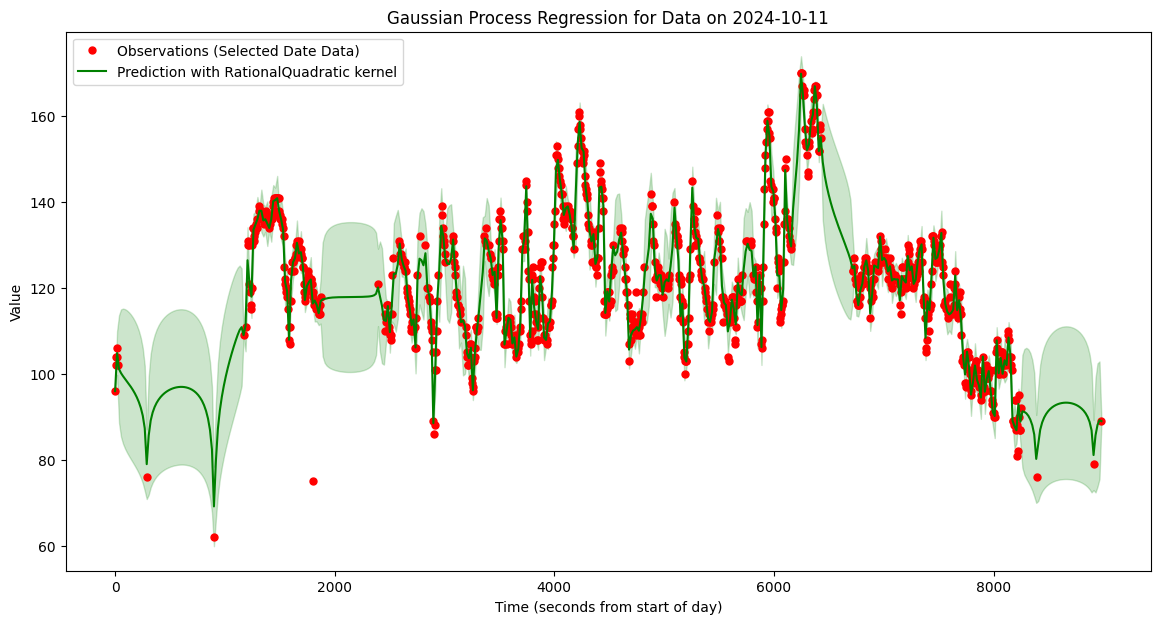

In [53]:
import numpy as np
from sklearn.gaussian_process.kernels import ConstantKernel as C, ExpSineSquared as Exp, RationalQuadratic as RQ, RBF, Matern as M
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from collections import defaultdict
from sklearn.utils.optimize import _check_optimize_result
from functools import partial
from sklearn.gaussian_process import GaussianProcessRegressor
import scipy.optimize

class MyGPR(GaussianProcessRegressor):
    def __init__(self, kernel=None, alpha=1e-10, optimizer="fmin_l_bfgs_b",
                n_restarts_optimizer=0, normalize_y=False, copy_X_train=True,
                max_iter=305000, gtol=1e-06):
        # Pass parameters to the base class
        super().__init__(kernel=kernel, alpha=alpha, optimizer=optimizer, 
                        n_restarts_optimizer=n_restarts_optimizer,
                        normalize_y=normalize_y, copy_X_train=copy_X_train)
        # Set custom parameters for optimizer
        self.max_iter = max_iter
        self.gtol = gtol

    def _constrained_optimization(self, obj_func, initial_theta, bounds):
        # Override optimizer if it is set to "fmin_l_bfgs_b"
        if self.optimizer == "fmin_l_bfgs_b":
            opt_res = scipy.optimize.minimize(
                obj_func,
                initial_theta,
                method="L-BFGS-B",
                jac=True,
                bounds=bounds,
                options={'maxiter': self.max_iter, 'gtol': self.gtol}  # Use custom max_iter and gtol
            )
            _check_optimize_result("lbfgs", opt_res)
            theta_opt, func_min = opt_res.x, opt_res.fun
        elif callable(self.optimizer):
            theta_opt, func_min = self.optimizer(obj_func, initial_theta, bounds=bounds)
        else:
            raise ValueError(f"Unknown optimizer {self.optimizer}.")
        
        return theta_opt, func_min

# Select data for a specific date, e.g., 2024-10-11
selected_date = datetime(2024, 10, 11).date()
time_value_pairs = last_7_days_data[selected_date]

# Convert times to a sequential numeric format (e.g., seconds from the start of the day)
start_time = datetime.combine(selected_date, time_value_pairs[0][0])
X = np.array([(datetime.combine(selected_date, t) - start_time).total_seconds() for t, _ in time_value_pairs]).reshape(-1, 1)
y = np.array([float(value) for _, value in time_value_pairs])

# Generate input data for prediction in a broader range (for smoother plots)
x = np.atleast_2d(np.linspace(X.min(), X.max(), 500)).T

# Second GP model with a combination of Constant and RationalQuadratic kernels
kernel = C() * RQ(length_scale=1 )
gp = MyGPR(kernel=kernel, n_restarts_optimizer=4)
gp.fit(X, y)

# Make predictions
y_pred_2, sigma_2 = gp.predict(x, return_std=True)

# Plotting the results
plt.figure(figsize=(14, 7))
plt.plot(X, y, 'r.', markersize=10, label='Observations (Selected Date Data)')
# plt.plot(x, y_pred_1, 'b-', label='Prediction with ExpSineSquared kernel')
# plt.fill_between(x.ravel(), y_pred_1 - 1.96 * sigma_1, y_pred_1 + 1.96 * sigma_1, alpha=0.2, color='blue')
plt.plot(x, y_pred_2, 'g-', label='Prediction with RationalQuadratic kernel')
plt.fill_between(x.ravel(), y_pred_2 - 1.96 * sigma_2, y_pred_2 + 1.96 * sigma_2, alpha=0.2, color='green')
plt.xlabel("Time (seconds from start of day)")
plt.ylabel("Value")
plt.legend()
plt.title(f"Gaussian Process Regression for Data on {selected_date}")
plt.show()

In [5]:
import numpy as np
from sklearn.gaussian_process.kernels import ConstantKernel as C, ExpSineSquared as Exp, RationalQuadratic as RQ
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.utils.optimize import _check_optimize_result
import scipy.optimize

class MyGPR(GaussianProcessRegressor):
    def __init__(self, kernel=None, alpha=1e-10, optimizer="fmin_l_bfgs_b",
                 n_restarts_optimizer=0, normalize_y=False, copy_X_train=True,
                 max_iter=25000, gtol=1e-06):
        # Pass parameters to the base class
        super().__init__(kernel=kernel, alpha=alpha, optimizer=optimizer, 
                         n_restarts_optimizer=n_restarts_optimizer,
                         normalize_y=normalize_y, copy_X_train=copy_X_train)
        # Set custom parameters for optimizer
        self.max_iter = max_iter
        self.gtol = gtol

    def _constrained_optimization(self, obj_func, initial_theta, bounds):
        # Override optimizer if it is set to "fmin_l_bfgs_b"
        if self.optimizer == "fmin_l_bfgs_b":
            opt_res = scipy.optimize.minimize(
                obj_func,
                initial_theta,
                method="L-BFGS-B",
                jac=True,
                bounds=bounds,
                options={'maxiter': self.max_iter, 'gtol': self.gtol}  # Use custom max_iter and gtol
            )
            _check_optimize_result("lbfgs", opt_res)
            theta_opt, func_min = opt_res.x, opt_res.fun
        elif callable(self.optimizer):
            theta_opt, func_min = self.optimizer(obj_func, initial_theta, bounds=bounds)
        else:
            raise ValueError(f"Unknown optimizer {self.optimizer}.")
        
        return theta_opt, func_min

# Sample grouped_data from the previous step
# grouped_data = {
#     datetime(2024, 10, 11).date(): [(datetime(2024, 10, 11, 7, 10, 55).time(), '112'),
#                                     (datetime(2024, 10, 11, 8, 15, 30).time(), '120'),
#                                     (datetime(2024, 10, 11, 10, 5, 45).time(), '98')]
# }

# Select data for a specific date, e.g., 2024-10-11
selected_date = datetime(2024, 10, 10).date()
time_value_pairs = grouped_data[selected_date]

# Convert times to a sequential numeric format (e.g., seconds from the start of the day)
start_time = datetime.combine(selected_date, time_value_pairs[0][0])
X = np.array([(datetime.combine(selected_date, t) - start_time).total_seconds() for t, _ in time_value_pairs]).reshape(-1, 1)
y = np.array([float(value) for _, value in time_value_pairs])

# Generate input data for prediction in a broader range (for smoother plots)
x = np.atleast_2d(np.linspace(X.min(), X.max(), 500)).T

# Define range for length_scale to tune
length_scale_range = np.linspace(1, 50, 2)  # Range of length scales to try
best_length_scale = None
best_mae = float('inf')

# Tune length_scale by evaluating mean absolute error (MAE)
for ls in length_scale_range:
    kernel = C() * RQ(length_scale=ls, alpha=1)
    gp = MyGPR(kernel=kernel, n_restarts_optimizer=4)
    gp.fit(X, y)
    y_pred, _ = gp.predict(X, return_std=True)  # Predict on training data to calculate error
    mae = mean_absolute_error(y, y_pred)
    
    if mae < best_mae:
        best_mae = mae
        best_length_scale = ls

# Print the best length scale
print(f"Optimal length_scale: {best_length_scale} with MAE: {best_mae}")

# Fit the model with the best length scale
kernel = C() * RQ(length_scale=best_length_scale, alpha=1)
gp = MyGPR(kernel=kernel, n_restarts_optimizer=4)
gp.fit(X, y)

# Make predictions for plotting
y_pred, sigma = gp.predict(x, return_std=True)

# Plotting the results
plt.figure(figsize=(14, 7))
plt.plot(X, y, 'r.', markersize=10, label='Observations (Selected Date Data)')
plt.plot(x, y_pred, 'b-', label=f'Prediction with tuned ExpSineSquared kernel (length_scale={best_length_scale})')
plt.fill_between(x.ravel(), y_pred - 1.96 * sigma, y_pred + 1.96 * sigma, alpha=0.2, color='blue')
plt.xlabel("Time (seconds from start of day)")
plt.ylabel("Value")
plt.legend()
plt.title(f"Gaussian Process Regression for Data on {selected_date}")
plt.show()

/Users/shikhharsiingh/miniforge3/envs/projects/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


KeyboardInterrupt: 

In [59]:
best_length_scale

np.float64(1.0)

/Users/shikhharsiingh/miniforge3/envs/projects/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/shikhharsiingh/miniforge3/envs/projects/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/shikhharsiingh/miniforge3/envs/projects/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  war

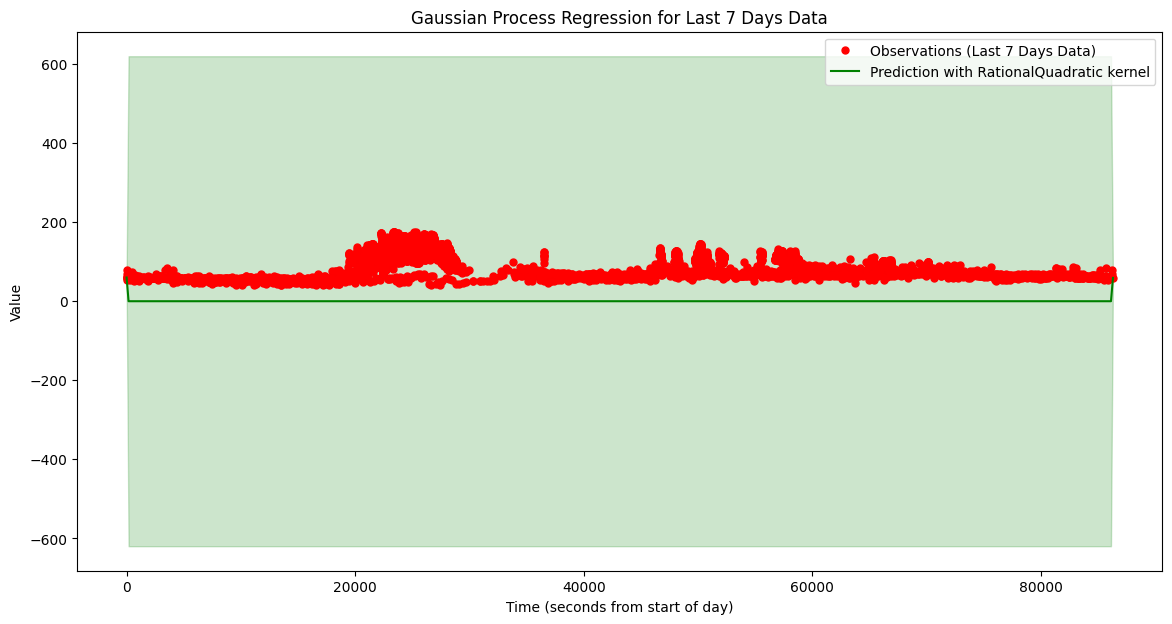

In [4]:
import numpy as np
from sklearn.gaussian_process.kernels import ConstantKernel as C, RationalQuadratic as RQ
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from collections import defaultdict
from sklearn.utils.optimize import _check_optimize_result
from sklearn.gaussian_process import GaussianProcessRegressor
import scipy.optimize

# Sample data over 100 days
# grouped_data = defaultdict(list)
# start_date = datetime(2024, 10, 1)
# for day in range(100):
#     current_date = (start_date + timedelta(days=day)).date()
#     times = [datetime(2024, 10, 1, hour, 0).time() for hour in range(24)]
#     values = np.sin(np.linspace(0, 2 * np.pi, 24)) + np.random.normal(0, 0.2, 24)  # Simulated daily pattern
#     grouped_data[current_date] = list(zip(times, values))


class MyGPR(GaussianProcessRegressor):
    def __init__(self, kernel=None, alpha=1e-10, optimizer="fmin_l_bfgs_b",
                 n_restarts_optimizer=0, normalize_y=False, copy_X_train=True,
                 max_iter=205000, gtol=1e-06):
        super().__init__(kernel=kernel, alpha=alpha, optimizer=optimizer, 
                         n_restarts_optimizer=n_restarts_optimizer,
                         normalize_y=normalize_y, copy_X_train=copy_X_train)
        self.max_iter = max_iter
        self.gtol = gtol

    def _constrained_optimization(self, obj_func, initial_theta, bounds):
        if self.optimizer == "fmin_l_bfgs_b":
            opt_res = scipy.optimize.minimize(
                obj_func,
                initial_theta,
                method="L-BFGS-B",
                jac=True,
                bounds=bounds,
                options={'maxiter': self.max_iter, 'gtol': self.gtol}
            )
            _check_optimize_result("lbfgs", opt_res)
            theta_opt, func_min = opt_res.x, opt_res.fun
        elif callable(self.optimizer):
            theta_opt, func_min = self.optimizer(obj_func, initial_theta, bounds=bounds)
        else:
            raise ValueError(f"Unknown optimizer {self.optimizer}.")
        
        return theta_opt, func_min

# Concatenate data across 100 days
X_last_7, y_last_7 = [], []
for date in last_7_dates:
    time_value_pairs = grouped_data[date]
    start_time = datetime.combine(date, time_value_pairs[0][0])
    X_last_7.extend([(datetime.combine(date, t) - start_time).total_seconds() for t, _ in time_value_pairs])
    y_last_7.extend([float(value) for _, value in time_value_pairs])


X_last_7 = np.array(X_last_7).reshape(-1, 1)
y_last_7 = np.array(y_last_7)

# Generate input data for prediction over the selected time range
x_pred = np.linspace(X_last_7.min(), X_last_7.max(), 500).reshape(-1, 1)

# Define the kernel
kernel = C() * RQ(length_scale=1, alpha=1)
gp = MyGPR(kernel=kernel, n_restarts_optimizer=10)
gp.fit(X_last_7, y_last_7)

# Make predictions
y_pred, sigma = gp.predict(x_pred, return_std=True)

# Plotting the results
plt.figure(figsize=(14, 7))
plt.plot(X_last_7, y_last_7, 'r.', markersize=10, label='Observations (Last 7 Days Data)')
plt.plot(x_pred, y_pred, 'g-', label='Prediction with RationalQuadratic kernel')
plt.fill_between(x_pred.ravel(), y_pred - 1.96 * sigma, y_pred + 1.96 * sigma, alpha=0.2, color='green')
plt.xlabel("Time (seconds from start of day)")
plt.ylabel("Value")
plt.legend()
plt.title("Gaussian Process Regression for Last 7 Days Data")
plt.show()

In [13]:
import json
grouped_data = dict(grouped_data)

# Convert to JSON format

grouped_data_str_keys = {str(date): values for date, values in grouped_data.items()}
grouped_data_json = json.dumps(grouped_data_str_keys, default=str)  # Use default=str to handle datetime serialization

# Optional: Write JSON to a file
with open('grouped_data.json', 'w') as json_file:
    json_file.write(grouped_data_json)